# Spraak analyse & Synthese

## 1.1. The general research question
Can emotion be detected from a recording of voice soundfiles? Can we use the vibration of vocal cords from sound recordings to measure which emotion the speaker has?

## specific research question
Can i build a small Neural Network that distinguishes 8 different emotions. i.e;(01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised) from sound recordings of different actors?
I would like to answer this question by building my own neural network and train and test the network with 1440 sound recordings of 192 recordings of every emotion and 96 neutral recordings. I aim to train with cross-validation for obtaining the best accuracy. An accuracy of approximately 50% should be reachable.




# 2 The data
## 2.1. The data from the outside

### The RAVDESS emotion database ;
### The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)

**source**: The data can be downloaded from canvas in Ravdess.zip or from Zenodo.com <br>
**license**:
The license is only for non-commercial use. <br>
**location**: 
The data with 1440 .wav files, totalling 590,3 MB is mounted in google drive; MyDrive. <br>
**structure**: <br>
File naming convention;

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

Filename identifiers;

Modality (01 = full-AV, 02 = video-only, 03 = audio-only). <br>
Vocal channel (01 = speech, 02 = song).<br>
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).<br>
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.<br>
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").<br>
Repetition (01 = 1st repetition, 02 = 2nd repetition).<br>
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).<br>

Filename example: 02-01-06-01-02-01-12.mp4 

Video-only (02)<br>
Speech (01)<br>
Fearful (06)<br>
Normal intensity (01)<br>
Statement "dogs" (02)<br>
1st Repetition (01)<br>
12th Actor (12)<br>
Female, as the actor ID number is even.

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.chdir("/content/gdrive/MyDrive/Ravdess")
path = "/content/gdrive/MyDrive/Ravdess/Ravdess/"

In [4]:
sound_files = os.listdir("Ravdess")
print(len(sound_files))

1440


## 2.2. The data from the inside
### 2.2.1. Visualizing the waveform

explorations of the data 
visualizations and some acoustic analyses

In [5]:
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

Some wavefroms and mfcc's of complete recordings with different emotions:


happy


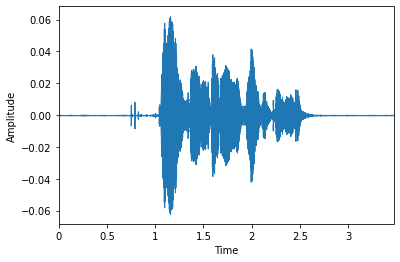

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


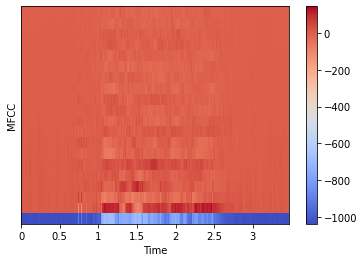

calm


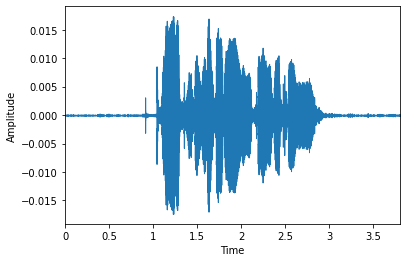

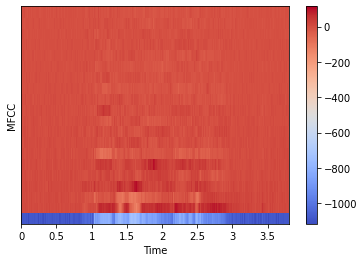

sad


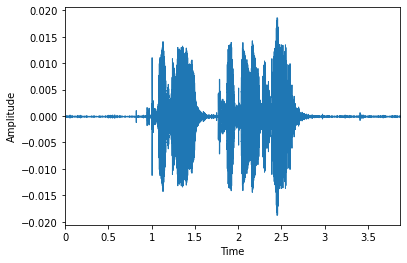

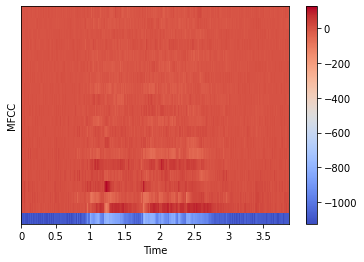

happy


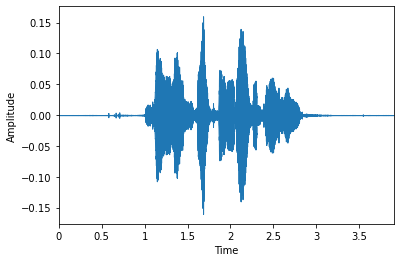

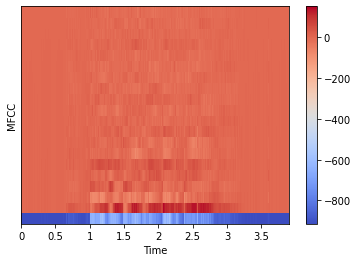

sad


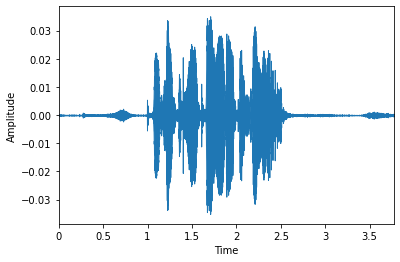

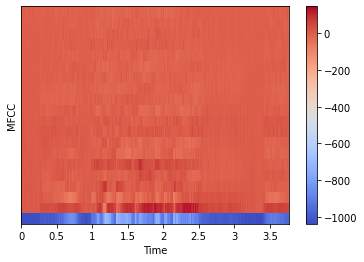

In [6]:

emotion = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}
# print(emotion.keys())
for sound in sound_files[:5]:
    samples, sample_rate = librosa.load(path+sound, sr=None)

    print(emotion[int(sound[7])])
    
    librosa.display.waveplot(samples, sr=sample_rate)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    
    MFCCS = librosa.feature.mfcc(samples, n_fft=256, hop_length=80, win_length=240, n_mfcc=20)
    librosa.display.specshow(
        data = MFCCS,
        x_axis='time',
        sr = sample_rate,
        hop_length = 80   
    )
    plt.xlabel("Time")
    plt.ylabel("MFCC")
    plt.colorbar()
    plt.show()

    IPython.display.Audio(samples, rate=sample_rate)

Selecting the part of the recording with the most voiuced information in it.

happy


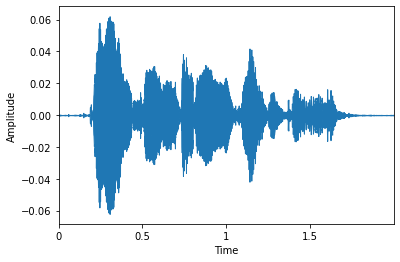

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


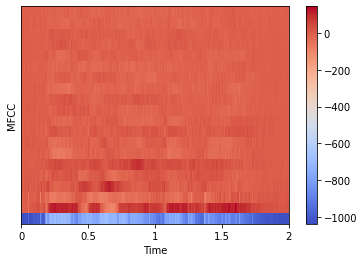

calm


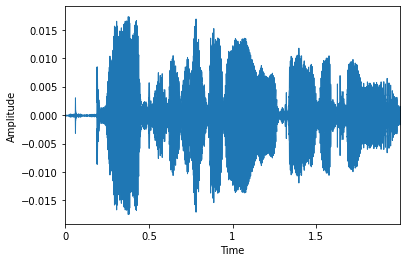

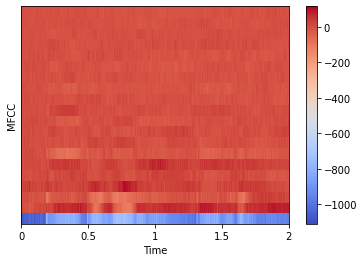

sad


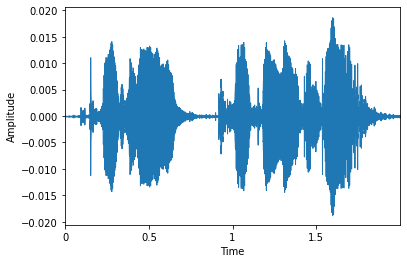

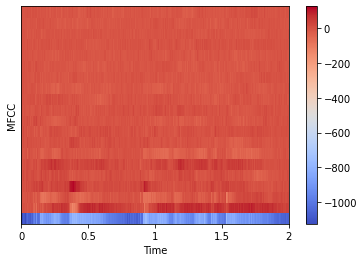

happy


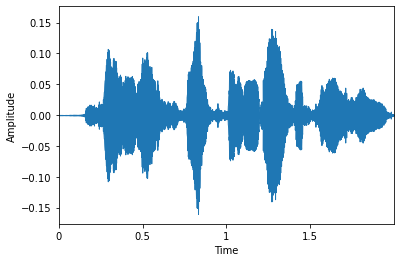

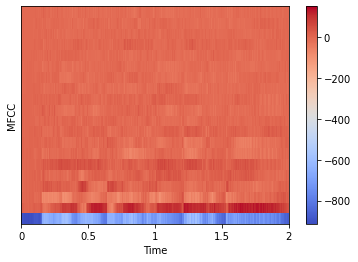

sad


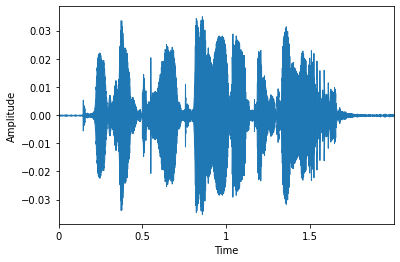

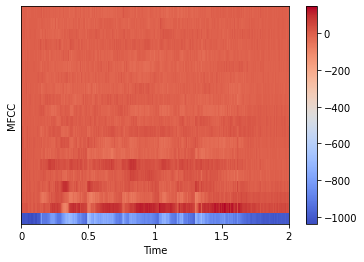

In [7]:
for sound in sound_files[:5]:
    samples, sample_rate = librosa.load(path+sound, sr=None)
    start_time = 0.85
    end_time = 2.85

    print(emotion[int(sound[7])])
    
    librosa.display.waveplot(samples[round(start_time*sample_rate):round(end_time*sample_rate)], sr=sample_rate)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    
    MFCCS = librosa.feature.mfcc(samples[round(start_time*sample_rate):round(end_time*sample_rate)], n_fft=256, hop_length=80, win_length=240, n_mfcc=20)
    librosa.display.specshow(
        data = MFCCS,
        x_axis='time',
        sr = sample_rate,
        hop_length = 80   
    )
    plt.xlabel("Time")
    plt.ylabel("MFCC")
    plt.colorbar()
    plt.show()


Some recordings are longer then others but with this time range only a small part wil be cut of from the longer recordings and it will minimize the white noise in the most recordings.

When i listen to the sound recordings, i find it hard to distinguish what the supposed emotion should be. From the first look at the visualisations, i don't necceserily see big differences between the different emotions. I'm curious to see if the neural network can do any better.

##data selection: <br>
cleaning, restrictions on the size of the data points...
preparation of the data for the input: analyses, conversions
creation of the dataset: a complete data table
network: architecture, data generator.


Some statistics on the data:

In [8]:
Female, Male, Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, Surprised, normal, strong = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

for sound in sound_files:
  if (int(sound[18:20]) % 2) == 0:
    # Female if even
    Female += 1
  else:
    Male += 1
  if int(sound[7:8]) == 1:
    Neutral += 1
  if int(sound[7:8]) == 2:
    Calm += 1
  if int(sound[7:8]) == 3:
    Happy += 1
  if int(sound[7:8]) == 4:
    Sad += 1
  if int(sound[7:8]) == 5:
    Angry += 1
  if int(sound[7:8]) == 6:
    Fearful += 1
  if int(sound[7:8]) == 7:
    Disgust += 1
  if int(sound[7:8]) == 8:
    Surprised += 1
  if int(sound[10:11]) == 1:
    normal += 1
  if int(sound[10:11]) == 2:
    strong += 1

print('Female: ', Female, ', Male: ', Male)
print('Neutral: ', Neutral, 'Calm: ', Calm, 'Happy: ', Happy, 'Sad: ', Sad, 'Angry: ', Angry, 'Fearful: ', Fearful, 'Disgust: ', Disgust, 'Surprised: ', Surprised)
print('Intensity strong: ', strong, 'and normal: ', normal)

Female:  720 , Male:  720
Neutral:  96 Calm:  192 Happy:  192 Sad:  192 Angry:  192 Fearful:  192 Disgust:  192 Surprised:  192
Intensity strong:  672 and normal:  768


The data is approximately distributed evenly. This distribution wil not have a significant effect on the probability of one emotion more then another so we can use this dataset as it is.

### 2.3.1. The minimum duration for training

Changes in the speech through time may be important to successful classification. If we are restricted to convolutional networks, the duration of input tokens should be fixed. Perhaps 1 second is a reasonable duration. This becomes feasible if most recordings are longer than 1 second:

In [9]:
MINIMUM_DURATION = 1.0   # seconds
start_time = 0.85
end_time = 2.85

for wav in os.scandir(path):
    samples, sample_rate = librosa.load(wav.path, sr=None)
    duration = len(samples) / sample_rate
    if duration < 1.5 * 2:
        print("Duration of \"", wav.path, "\" is only ", duration, " seconds.", sep='')


Duration of "/content/gdrive/MyDrive/Ravdess/Ravdess/03-01-08-01-02-02-11.wav" is only 2.969625 seconds.
Duration of "/content/gdrive/MyDrive/Ravdess/Ravdess/03-01-02-01-02-02-13.wav" is only 2.9362708333333334 seconds.


The shortest recording is 2.936 seconds long. So we can use all data, which is 1440 recordings. During training i will use a different sample of 1 second from each recording every time. The input for the model will be the MFCC coefficients of the sound recording.

Time runs in the horizontal direction. The function `tf.keras.layers.Conv1D`, however, expects the 20 features horizontally, and the time sequence vertically. Thus, we have to transpose the MFCC object.

In [10]:
dataset = pd.DataFrame(columns=['mfcc', 'emotion'])

def prepair_dataframes(path, sound_files, emotion):

    for sound in tqdm(sound_files):

        samples, sample_rate = librosa.load(path+sound, sr=None)

        # print(emotion[int(sound[7])])
        MFCCS = librosa.feature.mfcc(samples[round(start_time*sample_rate):round(end_time*sample_rate)], 
                                     n_fft=256, hop_length=80, win_length=240, n_mfcc=20)

        # Safe data as a pair of mfcc's and the emotion label.
        dataset.loc[len(dataset.index)] = [np.transpose(MFCCS), int(sound[7]) ]

prepair_dataframes(path, sound_files, emotion)

  0%|          | 0/1440 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
100%|██████████| 1440/1440 [00:43<00:00, 33.13it/s]


In [11]:
dataset.groupby('emotion').size()

emotion
1     96
2    192
3    192
4    192
5    192
6    192
7    192
8    192
dtype: int64

Create a training set and test set. Before splitting, i shuffle the data so that de speaking actors are shuffled over the dataset. We cannot use train_test_split from sklearn because we need to grab a different sample from the sound file each time. So i split the data manually.

In [12]:
rng = np.random.default_rng()

# shuffle dataframe
# rng.shuffle(dataset)
dataset = dataset.sample(frac=1).reset_index(drop=True)

test_fraction = 0.2
nr_training_dataPairs = round((1-test_fraction) * len(dataset))
per_cat = round(nr_training_dataPairs /len(emotion))
print(per_cat)

# slicing into training set and test set
# train = dataset[:nr_training_dataPairs]
train = pd.DataFrame(columns=['mfcc', 'emotion'])

for e in emotion:
  train = train.append(dataset[dataset['emotion'] == e][:per_cat], ignore_index=True)

test = dataset[nr_training_dataPairs:]
print('Size of training set: ', len(train))
print('Size of test set: ', len(test))

144
Size of training set:  1104
Size of test set:  288


In [13]:

train = train.sample(frac=1).reset_index(drop=True)
train.groupby('emotion').size(), train.head()

(emotion
 1     96
 2    144
 3    144
 4    144
 5    144
 6    144
 7    144
 8    144
 dtype: int64,                                                 mfcc emotion
 0  [[-961.5932, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...       5
 1  [[-1046.9807, 0.3887806, 0.2596028, 0.22013962...       1
 2  [[-940.7011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...       6
 3  [[-1019.1444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....       4
 4  [[-819.5944, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...       6)

In [47]:
EPOCH_SIZE = 1024   # some fake number in the vicinity of the data size
BATCH_SIZE = 32  # the number of data pairs that will be processed together
NUMBER_OF_SAMPLES = 16000   # 1 second at 16 kHz sample rate

frame_length_in_seconds = 0.005
minimum_number_of_frames = round(MINIMUM_DURATION / frame_length_in_seconds)
frame_length_in_samples = round(frame_length_in_seconds * sample_rate)
NUMBER_OF_MFCC_CHANNELS = 20

In [48]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return EPOCH_SIZE // BATCH_SIZE
  def __getitem__(self, ignored_index):
    inputs = np.zeros(shape=(BATCH_SIZE, minimum_number_of_frames, NUMBER_OF_MFCC_CHANNELS))
    targets = np.zeros(shape=(BATCH_SIZE,))
    for i in range(0, BATCH_SIZE):
        index = rng.integers(0,len(self.dataset))
        data_pair = self.dataset.iloc[index]
        number_of_frames = data_pair.mfcc.shape[0]
        starting_sample = rng.integers(number_of_frames - minimum_number_of_frames + 1)
        inputs[i, :, :] = data_pair.mfcc[starting_sample : starting_sample + minimum_number_of_frames]
        targets[i] = data_pair.emotion
    return inputs, targets

The number of input nodes for the model is 200 time-steps by 20 mfcc channels.

Flattening collapses the nodes into 1 single layer for Dense layer.

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(200, 20)),
    tf.keras.layers.Conv1D(64, kernel_size=9, activation='relu'),
    tf.keras.layers.Conv1D(32, kernel_size=7, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu'),
    tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(9,activation='softmax'),
])


## Training

In [32]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #
    metrics = ['accuracy']
)

training_data_generator = DataGenerator(train)
testing_data_generator = DataGenerator(test)

model.fit(
    x = training_data_generator,
    epochs=100,
    verbose=2,
    steps_per_epoch = EPOCH_SIZE // BATCH_SIZE,
    validation_data = testing_data_generator
)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 - 3s - loss: 66.6447 - accuracy: 0.0000e+00 - val_loss: 5518700.5000 - val_accuracy: 0.1310 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 1s - loss: 5437784.0000 - accuracy: 0.1400 - val_loss: 233677.3281 - val_accuracy: 0.1370 - 1s/epoch - 1s/step
Epoch 3/100
1/1 - 1s - loss: 229287.7812 - accuracy: 0.1260 - val_loss: 70568.5938 - val_accuracy: 0.1140 - 1s/epoch - 1s/step
Epoch 4/100
1/1 - 1s - loss: 68120.9297 - accuracy: 0.1190 - val_loss: 2.2764 - val_accuracy: 0.1250 - 1s/epoch - 1s/step
Epoch 5/100
1/1 - 1s - loss: 2.2249 - accuracy: 0.1210 - val_loss: 1841.7653 - val_accuracy: 0.1160 - 1s/epoch - 1s/step
Epoch 6/100
1/1 - 1s - loss: 1996.3158 - accuracy: 0.1290 - val_loss: 7515.5142 - val_accuracy: 0.1240 - 1s/epoch - 1s/step
Epoch 7/100
1/1 - 2s - loss: 7922.8271 - accuracy: 0.1450 - val_loss: 2.2477 - val_accuracy: 0.1770 - 2s/epoch - 2s/step
Epoch 8/100
1/1 - 1s - loss: 2.3520 - accuracy: 0.1220 - val_loss: 2.2829 - val_accuracy: 0.1770 - 1s/epoch - 1s/step
Epoch 9/100
1/1 - 1s 

In [33]:
#
# Test the model on all our data.
# Note: the test data is the same as the training data!
#
training_loss, training_acc = model.evaluate(training_data_generator, verbose=2)
print('Accuracy on training data:', training_acc)

1/1 - 0s - loss: 2.0702 - accuracy: 0.1560 - 434ms/epoch - 434ms/step
Accuracy on training data: 0.15600000321865082


# Testing

In [34]:
number_of_correct = 0
input = np.zeros(shape=(1, minimum_number_of_frames, NUMBER_OF_MFCC_CHANNELS))

for i, data_pair in test.iterrows():
    input[0, 0:minimum_number_of_frames, :] = data_pair.mfcc[0:minimum_number_of_frames, :]
    predicted = model.predict(input)
    predicted = np.argmax(predicted, axis=1) 
    print('Prediction emotion by model: ', emotion[int(predicted)])
    print('True emotion:                ', emotion[int(data_pair.emotion)])
    number_of_correct += ( predicted == [data_pair.emotion])
print("Correct: ", number_of_correct, " out of ", len(test), sep='')

Prediction emotion by model:  fearful
True emotion:                 angry
Prediction emotion by model:  fearful
True emotion:                 sad
Prediction emotion by model:  fearful
True emotion:                 angry
Prediction emotion by model:  fearful
True emotion:                 fearful
Prediction emotion by model:  fearful
True emotion:                 surprised
Prediction emotion by model:  fearful
True emotion:                 disgust
Prediction emotion by model:  fearful
True emotion:                 sad
Prediction emotion by model:  fearful
True emotion:                 sad
Prediction emotion by model:  fearful
True emotion:                 calm
Prediction emotion by model:  fearful
True emotion:                 happy
Prediction emotion by model:  fearful
True emotion:                 fearful
Prediction emotion by model:  fearful
True emotion:                 angry
Prediction emotion by model:  fearful
True emotion:                 happy
Prediction emotion by model:  fearf

In [35]:
NUMBER_OF_SEARCHES = 99
input = np.zeros(shape=(NUMBER_OF_SEARCHES, minimum_number_of_frames, NUMBER_OF_MFCC_CHANNELS))
number_of_correct = 0
for i, data_pair in test.iterrows():
    number_of_frames = data_pair.mfcc.shape[0]
    for isearch in range(0,NUMBER_OF_SEARCHES):
        starting_sample = rng.integers(number_of_frames - minimum_number_of_frames + 1)
        input[isearch, 0:minimum_number_of_frames, :] = data_pair.mfcc[starting_sample:starting_sample+minimum_number_of_frames, :]
    predicted = model.predict(input)
    predicted = np.argmax(predicted)
    emo_is_predicted = ( np.sum(predicted) >= NUMBER_OF_SEARCHES / 2 )
    print('Prediction emotion by model: ', emotion[int(predicted)])
    print('True emotion:                ', emotion[int(data_pair.emotion)])
    number_of_correct += ( emo_is_predicted == data_pair.emotion)
print("Correct: ", number_of_correct, " out of ", len(test), sep='')

Prediction emotion by model:  fearful
True emotion:                 angry
Prediction emotion by model:  fearful
True emotion:                 sad
Prediction emotion by model:  fearful
True emotion:                 angry
Prediction emotion by model:  fearful
True emotion:                 fearful
Prediction emotion by model:  fearful
True emotion:                 surprised
Prediction emotion by model:  fearful
True emotion:                 disgust
Prediction emotion by model:  fearful
True emotion:                 sad
Prediction emotion by model:  fearful
True emotion:                 sad
Prediction emotion by model:  fearful
True emotion:                 calm
Prediction emotion by model:  fearful
True emotion:                 happy
Prediction emotion by model:  fearful
True emotion:                 fearful
Prediction emotion by model:  fearful
True emotion:                 angry
Prediction emotion by model:  fearful
True emotion:                 happy
Prediction emotion by model:  fearf

I think it predicts only one class at this point because on the little data that i trained it on (one batch of 32 samples) 1 class may be dominant so it learns that that one class has the highest probability.

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 192, 64)           11584     
                                                                 
 conv1d_9 (Conv1D)           (None, 186, 32)           14368     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 93, 32)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 89, 32)            5152      
                                                                 
 conv1d_11 (Conv1D)          (None, 87, 16)            1552      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 43, 16)           0         
 1D)                                                  

# Memory footprint

The number of input nodes is. 200 time steps * 20 mfcc channels = 4000 input nodes.

The number of parameters equals 11584 + 14368 + 5152 + 1552 + 88192 + 8256 + 585 = 129.689.

The number of nodes is 4000 + 12288 + 5952 + 2976 + 2848 + 2784 + 688 + 128 + 64 + 9 = 31.737
This comes down to 153.330 floats and that equals to 613320 bytes.

# cross-validation

1440 : 32 = 45. So i want to make 100 batches of randomly chosen 32 samples from the dataset so it will be trained on most parts of the data. 

In [1]:
N = len(dataset)
start_point = 0
nr_of_slices = 45
min_nr = N // nr_of_slices
remain = N % nr_of_slices
global_correct = 0

for islice in range(0, 45):  
    end_point = start_point + min_nr + (islice < remain)

    test_set = dataset.iloc[start_point:end_point]
    train_set = dataset.iloc[:start_point].append(dataset.iloc[end_point:])

    islice_train = DataGenerator(train_set)

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   
        metrics = ['accuracy']
    )

    #  Train
    model.fit(
        x = islice_train,
        epochs=100,
        verbose=0,
        steps_per_epoch = EPOCH_SIZE // BATCH_SIZE,
    )

    training_loss, training_acc = model.evaluate(islice_train, verbose=2)
    print('\nAccuracy on slice {} training data: '.format(islice), training_acc)

    #  Test
    correct = 0
    test_i = np.zeros(shape=(NUMBER_OF_SEARCHES, minimum_number_of_frames, 20))
    islice_test = DataGenerator(test_set)

    for mfcc, emo in islice_test:
        number_of_frames = mfcc.shape[0]
        for isearch in range(0, NUMBER_OF_SEARCHES):
          starting_sample = rng.integers(number_of_frames - minimum_number_of_frames + 1)

          test_i[isearch, 0:minimum_number_of_frames, :] = mfcc[starting_sample:starting_sample+minimum_number_of_frames, :]

        predict = model.predict(test_i)
        predict = np.argmax(predict, axis=1)
        correct += (int(predict) == int(emo))
    print("Correct: ", correct, 'out of ', len(islice_test_target))

    global_correct += correct
    start_point = end_point

print("Average test accuracy: ", global_correct / N)

The model doesn't seem to get any better as more batches are trained with 100 epochs each.  With 2000 epochs the accuracy actually seems worse. During training of 1 batch of size 32 with 100 epochs, i noticed the loss and accuracy is not improving after around 50 epochs already. Maybe 2000 epochs is overfitting. So i stick with 100 epochs per batch. In some of the batches 37% accuracy is achieved, but then it lowers again.

# discussion
## Summery of results
summary, with critical assessment of what went well and of the remaining problems

During training the model does not seem to get better with each batch. maybe this is due to something in my code. The model does achieve an accuracy of 28% which is on itself not really bad but an accuracy of 50% could be achieved. There seem to be something wierd with the prediction of a class because it seems to predict the same class for everything. i'm not sure if this is due to something in my code aswell. 


## To what extent can we answer the specific research question?

An accuracy of 28% is more than guessing randomly out of 8 classes so to a certain degree, my model can distuinguish different emotions from the mfcc's of these sound recordings.
But still, there is a lot of room for improvement.

## To what extent can we answer the general research question?

Does this specific question generalize to data outside our dataset?


In this dataset there were 24 different actors. So we could calculate how well the results will generalize to new speakers.
Also there might be a difference in the recordings of real emotions and acted (or fake) emotions. But this is also a lot harder to research in a controlled invironment. 

# conclusion: 


In this study, I tried to investigate whether a neural network can recognize the emotion by the MFCC coefficients of a sample of one second from the recording on the basis of 1440 recordings of 24 different actors in 8 different emotions and two different sentences. The neural network i trained could do this with an accuracy of 25% which is more than guessing randomly so we can conclude that a model is capable of recognizing emotions on mfcc coefficints from a sound recording. Maybe with some more pre-processing of the data, like filter out the noise at the beginning and at the end of a recording, so that the sample of 1 second from a recording has as much voiced data in it to work with. For further research i'm curious if there is a big difference between real emotion and acted emotion (which can be real as well if it's a good actor). 